<a href="https://colab.research.google.com/github/sumkh/ITI110_AgenticRAG/blob/main/app_colab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI Tutor Chatbot (Version 2.1)


### Setting Up - Install Requirements (Restart Session after installation)

In [1]:
%%capture
%pip install langchain-groq huggingface_hub transformers langchain langchain_huggingface langgraph langchain-core langchain-text-splitters langchain-community chromadb langchain-chroma langsmith docling langchain-docling sentence_transformers

### Load Packages and Utils

In [1]:
# Download required files from Github repo
!wget https://github.com/sumkh/NYP_Dataset/raw/refs/heads/main/Documents.zip
!unzip -o /content/Documents.zip


--2025-02-17 13:05:24--  https://github.com/sumkh/NYP_Dataset/raw/refs/heads/main/Documents.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sumkh/NYP_Dataset/refs/heads/main/Documents.zip [following]
--2025-02-17 13:05:24--  https://raw.githubusercontent.com/sumkh/NYP_Dataset/refs/heads/main/Documents.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18510909 (18M) [application/zip]
Saving to: ‘Documents.zip’

Documents.zip       100%[===================>]  17.65M   109MB/s    in 0.2s    

2025-02-17 13:05:25 (109 MB/s) - ‘Documents.zip’ saved [18510909/18510909]

Archive:  /content/Docume

In [2]:
import os
import csv
import json
import hashlib
import uuid
import logging
from typing import List, Optional, Union, Literal, Dict
from dataclasses import dataclass, field

# LangChain & related imports
from langchain_core.tools import tool, StructuredTool
from pydantic import BaseModel, Field

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import EnsembleRetriever, ContextualCompressionRetriever

# Extraction for Documents
from langchain_docling.loader import ExportType
from langchain_docling import DoclingLoader
from docling.chunking import HybridChunker

# Extraction for HTML
from langchain_community.document_loaders import WebBaseLoader
from urllib.parse import urlparse


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configurations and Get the API key from the environment variable
EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"

In [3]:
# =============================================================================
#                         Document Extraction Functions
# =============================================================================

def extract_documents(doc_path: str) -> List[str]:
    """
    Recursively collects all file paths from folder 'doc_path'.
    Used by ExtractDocument.load_files() to find documents to parse.
    """
    extracted_docs = []

    for root, _, files in os.walk(doc_path):
        for file in files:
            file_path = os.path.join(root, file)
            extracted_docs.append(file_path)
    return extracted_docs


def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))


def load_file(file_path: str) -> List[Document]:
    """
    Load a file from the given path and return a list of Document objects.
    """
    _documents = []

    # Load the file and extract the text chunks
    try:
        loader = DoclingLoader(
            file_path = file_path,
            export_type = ExportType.DOC_CHUNKS,
            chunker = HybridChunker(tokenizer=EMBED_MODEL_ID),
        )
        docs = loader.load()
        logger.info(f"Total parsed doc-chunks: {len(docs)} from Source: {file_path}")

        for d in docs:
            # Tag each document's chunk with the source file and a unique ID
            doc = Document(
                page_content=d.page_content,
                metadata={
                    "source": file_path,
                    "doc_id": _generate_uuid(d.page_content),
                    "source_type": "file",
                }
            )
            _documents.append(doc)
        logger.info(f"Total generated LangChain document chunks: {len(_documents)}\n.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents


# Define function to load documents from a folder
def load_files_from_folder(doc_path: str) -> List[Document]:
    """
    Load documents from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = extract_documents(doc_path)

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_file(file_path))

    return _documents

# =============================================================================
# Load structured data in csv file to LangChain Document format
def load_mcq_csvfiles(file_path: str) -> List[Document]:
    """
    Load structured data in mcq csv file from the given file path and return a list of Document object.
    Expected format: each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
    """
    _documents = []

    # iterate through each csv file and load each row into _dict_per_question format
    # Ensure we process only CSV files
    if not file_path.endswith(".csv"):
        return _documents  # Skip non-CSV files
    try:
        # Open and read the CSV file
        with open(file_path, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                # Ensure required columns exist in the row
                if not all(k in row for k in ["mcq_number", "mcq_type", "text_content"]): # Ensure required columns exist and exclude header
                    logger.error(f"Skipping row due to missing fields: {row}")
                    continue
                # Tag each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
                doc = Document(
                    page_content = row["text_content"], # text_content segment is separated by "|"
                    metadata={
                        "source": f"{file_path}_{row['mcq_number']}",  # file_path + mcq_number
                        "doc_id": _generate_uuid(f"{file_path}_{row['mcq_number']}"),  # Unique ID
                        "source_type": row["mcq_type"],  # MCQ type
                    }
                )
                _documents.append(doc)
            logger.info(f"Successfully loaded {len(_documents)} LangChain document chunks from {file_path}.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents

# Define function to load documents from a folder for structured data in csv file
def load_files_from_folder_mcq(doc_path: str) -> List[Document]:
    """
    Load mcq csv file from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = [
        os.path.join(doc_path, file) for file in os.listdir(doc_path)
        if file.endswith(".csv")  # Process only CSV files
    ]

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_mcq_csvfiles(file_path))

    return _documents


# =============================================================================
#                         Website Extraction Functions
# =============================================================================
def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))

def ensure_scheme(url):
    parsed_url = urlparse(url)
    if not parsed_url.scheme:
        return 'http://' + url  # Default to http, or use 'https://' if preferred
    return url

def extract_html(url: List[str]) -> List[Document]:
    if isinstance(url, str):
        url = [url]
    """
    Extracts text from the HTML content of web pages listed in 'web_path'.
    Returns a list of LangChain 'Document' objects.
    """
    # Ensure all URLs have a scheme
    web_paths = [ensure_scheme(u) for u in url]

    loader = WebBaseLoader(web_paths)
    loader.requests_per_second = 1
    docs = loader.load()

    # Iterate through each document, clean the content, removing excessive line return and store it in a LangChain Document
    _documents = []
    for doc in docs:
        # Clean the concent
        doc.page_content = doc.page_content.strip()
        doc.page_content = doc.page_content.replace("\n", " ")
        doc.page_content = doc.page_content.replace("\r", " ")
        doc.page_content = doc.page_content.replace("\t", " ")
        doc.page_content = doc.page_content.replace("  ", " ")
        doc.page_content = doc.page_content.replace("   ", " ")

        # Store it in a LangChain Document
        web_doc = Document(
            page_content=doc.page_content,
            metadata={
                "source": doc.metadata.get("source"),
                "doc_id": _generate_uuid(doc.page_content),
                "source_type": "web"
            }
        )
        _documents.append(web_doc)
    return _documents

# =============================================================================
#                         Vector Store Initialisation
# =============================================================================

embedding_model = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)

# Initialise vector stores
general_vs = Chroma(
    collection_name="general_vstore",
    embedding_function=embedding_model,
    persist_directory="./general_db"
)

mcq_vs = Chroma(
    collection_name="mcq_vstore",
    embedding_function=embedding_model,
    persist_directory="./mcq_db"
)

in_memory_vs = Chroma(
    collection_name="in_memory_vstore",
    embedding_function=embedding_model
)

# Split the documents into smaller chunks for better embedding coverage
def split_text_into_chunks(docs: List[Document]) -> List[Document]:
    """
    Splits a list of Documents into smaller text chunks using
    RecursiveCharacterTextSplitter while preserving metadata.
    Returns a list of Document objects.
    """
    if not docs:
        return []
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, # Split into chunks of 1000 characters
        chunk_overlap=200, # Overlap by 200 characters
        add_start_index=True
    )
    chunked_docs = splitter.split_documents(docs)
    return chunked_docs # List of Document objects


# =============================================================================
#                         Retrieval Tools
# =============================================================================

# Define a simple similarity search retrieval tool on msq_vs
class MCQRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(2, title="Number of Results", description="The number of results to retrieve.")

def mcq_retriever(input: str, k: int = 2) -> List[str]:
    # Retrieve the top k most similar mcq question documents from the vector store
    docs_func = mcq_vs.as_retriever(
        search_type="similarity",
        search_kwargs={
        'k': k,
        'filter':{"source_type": "mcq_question"}
    },
    )
    docs_qns = docs_func.invoke(input, k=k)

    # Extract the document IDs from the retrieved documents
    doc_ids = [d.metadata.get("doc_id") for d in docs_qns if "doc_id" in d.metadata]

    # Retrieve full documents based on the doc_ids
    docs = mcq_vs.get(where = {'doc_id': {"$in":doc_ids}})

    qns_list = {}
    for i, d in enumerate(docs['metadatas']):
        qns_list[d['source'] + " " + d['source_type']] = docs['documents'][i]

    return qns_list

# Create a StructuredTool from the function
mcq_retriever_tool = StructuredTool.from_function(
    func = mcq_retriever,
    name = "MCQ Retrieval Tool",
    description = (
    """
    Use this tool to retrieve MCQ questions set when Human asks to generate a quiz related to a topic.
    DO NOT GIVE THE ANSWERS to Human before Human has answered all the questions.

    If Human give answers for questions you do not know, SAY you do not have the questions for the answer
    and ASK if the Human want you to generate a new quiz and then SAVE THE QUIZ with Summary Tool before ending the conversation.


    Input must be a JSON string with the schema:
        - input (str): The search topic to retrieve MCQ questions set related to the topic.
        - k (int): Number of question set to retrieve.
        Example usage: input='What is AI?', k=5

    Returns:
    - A dict of MCQ questions:
    Key: 'metadata of question' e.g. './Documents/mcq/mcq.csv_Qn31 mcq_question' with suffix ['question', 'answer', 'answer_reason', 'options', 'wrong_options_reason']
    Value: Text Content

    """
    ),
    args_schema = MCQRetrievalTool,
    response_format="content",
    return_direct = False, # Return the response as a list of strings
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the general vector store
# Useful if the dataset has many similar documents
class GenRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(2, title="Number of Results", description="The number of results to retrieve.")

def gen_retriever(input: str, k: int = 2) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
general_retriever_tool = StructuredTool.from_function(
    func = gen_retriever,
    name = "Assistant References Retrieval Tool",
    description = (
    """
    Use this tool to retrieve reference information from Assistant reference database for Human queries related to a topic or
    and when Human asked to generate guides to learn or study about a topic.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
        Example usage: input='What is AI?', k=5
    Returns:
    - A list of retrieved document's content string.
    """
    ),
    args_schema = GenRetrievalTool,
    response_format="content",
    return_direct = False, # Return the content of the documents
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the in-memory vector store
# Query in-memory vector store only
class InMemoryRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(2, title="Number of Results", description="The number of results to retrieve.")

def in_memory_retriever(input: str, k: int = 2) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
in_memory_retriever_tool = StructuredTool.from_function(
    func = in_memory_retriever,
    name = "In-Memory Retrieval Tool",
    description = (
    """
    Use this tool when Human ask Assistant to retrieve information from documents that Human has uploaded.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
    """
    ),
    args_schema = InMemoryRetrievalTool,
    response_format="content",
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Web Extraction Tool
class WebExtractionRequest(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    url: str = Field(
        ...,
        title="url",
        description="urls to extract content from"
    )
    k: int = Field(5, title="Number of Results", description="The number of results to retrieve.")

# Extract content from a web URL, load into in_memory_vstore
def extract_web_path_tool(input: str, url: str, k: int = 5) -> List[str]:
    if isinstance(url, str):
        url = [url]
    """
    Extract content from the web URLs based on user's input.
    Args:
    - input: The input text to search for.
    - url: URLs to extract content from.
    - k: Number of results to retrieve.
    Returns:
     - A list of retrieved document's content string.
    """
    # Extract content from the web
    html_docs = extract_html(url)
    if not html_docs:
        return f"No content extracted from {url}."

    # Split the documents into smaller chunks for better embedding coverage
    chunked_texts = split_text_into_chunks(html_docs)
    in_memory_vs.add_documents(chunked_texts) # Add the chunked texts to the in-memory vector store

    # Extract content from the in-memory vector store
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs={
        'k': k,
        'lambda_mult': 0.25,
        'filter':{"source": {"$in": url}}
    },
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
web_extraction_tool = StructuredTool.from_function(
    func = extract_web_path_tool,
    name = "Web Extraction Tool",
    description = (
        "Assistant should use this tool to extract content from web URLs based on user's input, "
        "Web extraction is initially load into database and then return k: Number of results to retrieve"
    ),
    args_schema = WebExtractionRequest,
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Ensemble Retrieval from General and In-Memory Vector Stores
class EnsembleRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(5, title="Number of Results", description="The number of results to retrieve.")

def ensemble_retriever(input: str, k: int = 5) -> List[str]:
    # Use retriever of vector store to retrieve documents
    general_retrieval = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    in_memory_retrieval = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )

    ensemble_retriever = EnsembleRetriever(
        retrievers=[general_retrieval, in_memory_retrieval],
        weights=[0.5, 0.5]
    )
    docs = ensemble_retriever.invoke(input)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
ensemble_retriever_tool = StructuredTool.from_function(
    func = ensemble_retriever,
    name = "Ensemble Retriever Tool",
    description = (
    """
    Use this tool to retrieve information from reference database and
    extraction of documents that Human has uploaded.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
    """
    ),
    args_schema = EnsembleRetrievalTool,
    response_format="content",
    return_direct = False
    )


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
###############################################################################
# Define a Customised Wrapper from vLLM Wrapper
###############################################################################

from __future__ import annotations

import json
import warnings
from operator import itemgetter
from typing import (
    Any,
    AsyncIterator,
    Callable,
    Dict,
    Iterator,
    List,
    Literal,
    Mapping,
    Optional,
    Sequence,
    Tuple,
    Type,
    TypedDict,
    Union,
    cast,
)

from langchain_core._api import deprecated
from langchain_core.callbacks import (
    AsyncCallbackManagerForLLMRun,
    CallbackManagerForLLMRun,
)
from langchain_core.language_models import LanguageModelInput
from langchain_core.language_models.chat_models import (
    BaseChatModel,
    LangSmithParams,
    agenerate_from_stream,
    generate_from_stream,
)
from langchain_core.messages import (
    AIMessage,
    AIMessageChunk,
    BaseMessage,
    BaseMessageChunk,
    ChatMessage,
    ChatMessageChunk,
    FunctionMessage,
    FunctionMessageChunk,
    HumanMessage,
    HumanMessageChunk,
    InvalidToolCall,
    SystemMessage,
    SystemMessageChunk,
    ToolCall,
    ToolMessage,
    ToolMessageChunk,
)
from langchain_core.output_parsers import (
    JsonOutputParser,
    PydanticOutputParser,
)
from langchain_core.output_parsers.base import OutputParserLike
from langchain_core.output_parsers.openai_tools import (
    JsonOutputKeyToolsParser,
    PydanticToolsParser,
    make_invalid_tool_call,
    parse_tool_call,
)
from langchain_core.outputs import ChatGeneration, ChatGenerationChunk, ChatResult
from langchain_core.runnables import Runnable, RunnableMap, RunnablePassthrough
from langchain_core.tools import BaseTool
from langchain_core.utils import (
    from_env,
    get_pydantic_field_names,
    secret_from_env,
)
from langchain_core.utils.function_calling import (
    convert_to_openai_function,
    convert_to_openai_tool,
)
from langchain_core.utils.pydantic import is_basemodel_subclass
from pydantic import (
    BaseModel,
    ConfigDict,
    Field,
    SecretStr,
    model_validator,
)
from typing_extensions import Self

def _is_pydantic_class(obj: Any) -> bool:
    return isinstance(obj, type) and is_basemodel_subclass(obj)


class _FunctionCall(TypedDict):
    name: str

def _convert_dict_to_message(_dict: Mapping[str, Any]) -> BaseMessage:
    """Convert a dictionary to a LangChain BaseMessage."""
    role = _dict.get("role")
    name = _dict.get("name")
    id_ = _dict.get("id")

    if role == "user":
        return HumanMessage(content=_dict.get("content", ""), id=id_, name=name)
    elif role == "assistant":
        # For Azure or OpenAI-like usage, 'assistant' can have content or tool calls
        content = _dict.get("content") or ""
        additional_kwargs: Dict[str, Any] = {}
        tool_calls = []
        invalid_tool_calls = []
        if raw_tool_calls := _dict.get("tool_calls"):
            additional_kwargs["tool_calls"] = raw_tool_calls
            for raw_tool_call in raw_tool_calls:
                try:
                    tool_calls.append(parse_tool_call(raw_tool_call, return_id=True))
                except Exception as e:
                    invalid_tool_calls.append(
                        make_invalid_tool_call(raw_tool_call, str(e))
                    )
        return AIMessage(
            content=content,
            additional_kwargs=additional_kwargs,
            name=name,
            id=id_,
            tool_calls=tool_calls,
            invalid_tool_calls=invalid_tool_calls,
        )
    elif role in ("system", "developer"):
        # "developer" is a custom role used by some expansions
        # We store it in additional_kwargs if needed
        if role == "developer":
            additional_kwargs = {"__openai_role__": role}
        else:
            additional_kwargs = {}
        return SystemMessage(
            content=_dict.get("content", ""),
            name=name,
            id=id_,
            additional_kwargs=additional_kwargs,
        )
    elif role == "function":
        return FunctionMessage(
            content=_dict.get("content", ""), name=cast(str, _dict.get("name")), id=id_
        )
    elif role == "tool":
        # custom "tool" role
        additional_kwargs = {}
        if "name" in _dict:
            additional_kwargs["name"] = _dict["name"]
        return ToolMessage(
            content=_dict.get("content", ""),
            tool_call_id=cast(str, _dict.get("tool_call_id")),
            additional_kwargs=additional_kwargs,
            name=name,
            id=id_,
        )
    else:
        # fallback for other roles
        return ChatMessage(content=_dict.get("content", ""), role=role, id=id_)


def _format_message_content(content: Any) -> Any:
    """Format message content, removing blocks with type == 'tool_use' if present."""
    if content and isinstance(content, list):
        formatted_content = []
        for block in content:
            if (
                isinstance(block, dict)
                and block.get("type") == "tool_use"
            ):
                continue
            formatted_content.append(block)
        return formatted_content
    return content


def _convert_message_to_dict(message: BaseMessage) -> Dict[str, Any]:
    """Convert a LangChain BaseMessage to a dictionary (role/content)."""
    message_dict: Dict[str, Any] = {
        "content": _format_message_content(message.content)
    }

    # Some messages store 'name' in message.name or additional_kwargs['name']
    if (name := message.name or message.additional_kwargs.get("name")) is not None:
        message_dict["name"] = name

    if isinstance(message, ChatMessage):
        message_dict["role"] = message.role
    elif isinstance(message, HumanMessage):
        message_dict["role"] = "user"
    elif isinstance(message, AIMessage):
        message_dict["role"] = "assistant"
        if "tool_calls" in message.additional_kwargs:
            message_dict["tool_calls"] = message.additional_kwargs["tool_calls"]
            # filter to only certain properties
            tool_call_supported_props = {"id", "type", "function"}
            message_dict["tool_calls"] = [
                {k: v for k, v in tool_call.items() if k in tool_call_supported_props}
                for tool_call in message_dict["tool_calls"]
            ]
        # If tool calls present, empty string => None
        if "tool_calls" in message_dict:
            message_dict["content"] = message_dict["content"] or None
    elif isinstance(message, SystemMessage):
        # We store developer as __openai_role__ in additional_kwargs
        # But for a standard system message we keep role="system"
        if "__openai_role__" in message.additional_kwargs:
            message_dict["role"] = "developer"
        else:
            message_dict["role"] = "system"
    elif isinstance(message, ToolMessage):
        message_dict["role"] = "tool"
        message_dict["tool_call_id"] = message.tool_call_id
        supported_props = {"content", "role", "tool_call_id", "name"}
        message_dict = {k: v for k, v in message_dict.items() if k in supported_props}
    else:
        raise TypeError(f"Got unknown type of message: {type(message)}")

    return message_dict

def _convert_chunk_to_message_chunk(
    chunk: Mapping[str, Any], default_class: Type[BaseMessageChunk]
) -> BaseMessageChunk:
    choice = chunk["choices"][0]
    _dict = choice["delta"]
    role = cast(str, _dict.get("role"))
    content = cast(str, _dict.get("content") or "")
    additional_kwargs: Dict = {}
    if _dict.get("function_call"):
        function_call = dict(_dict["function_call"])
        if "name" in function_call and function_call["name"] is None:
            function_call["name"] = ""
        additional_kwargs["function_call"] = function_call
    if _dict.get("tool_calls"):
        additional_kwargs["tool_calls"] = _dict["tool_calls"]

    if role == "user" or default_class == HumanMessageChunk:
        return HumanMessageChunk(content=content)
    elif role == "assistant" or default_class == AIMessageChunk:
        if usage := (chunk.get("x_groq") or {}).get("usage"):
            input_tokens = usage.get("prompt_tokens", 0)
            output_tokens = usage.get("completion_tokens", 0)
            usage_metadata = {
                "input_tokens": input_tokens,
                "output_tokens": output_tokens,
                "total_tokens": usage.get("total_tokens", input_tokens + output_tokens),
            }
        else:
            usage_metadata = None
        return AIMessageChunk(
            content=content,
            additional_kwargs=additional_kwargs,
            usage_metadata=usage_metadata,  # type: ignore[arg-type]
        )
    elif role == "system" or default_class == SystemMessageChunk:
        return SystemMessageChunk(content=content)
    elif role == "function" or default_class == FunctionMessageChunk:
        return FunctionMessageChunk(content=content, name=_dict["name"])
    elif role == "tool" or default_class == ToolMessageChunk:
        return ToolMessageChunk(content=content, tool_call_id=_dict["tool_call_id"])
    elif role or default_class == ChatMessageChunk:
        return ChatMessageChunk(content=content, role=role)
    else:
        return default_class(content=content)  # type: ignore


class BaseChat_vLLMWrapper(BaseChatModel):
    """
    A wrapper for a vLLM model for chat.
    Replace `self._client._generate(...)` calls with the actual method from your LLM client.
    """

    # We'll assume you pass in `client` at init; we store it as `_client`.
    # If you also have default params, you could store them similarly.
    _client: Any
    streaming: bool = False
    """Whether to stream the results or not."""

    def __init__(self, client: Any, **kwargs: Any):
        """
        Args:
            client: The vLLM-like client instance that can be called to generate.
        """
        super().__init__(**kwargs)
        self._client = client


    def _convert_messages_to_prompt(self, messages: List[BaseMessage]) -> str:
        """
        Example method: convert a list of BaseMessage into a single string prompt.
        Adjust how you prefix roles, etc., depending on your LLM’s needs.
        """
        lines = []

        # If messages is a dictionary, convert it to a list containing the dictionary
        if isinstance(messages, dict):
            messages = [messages]

        for m in messages:
            # role = m.role if m.role else m.__class__.__name__
            role = m.get("type", None) if isinstance(m, dict) else (m.type if hasattr(m, 'type') else m.__class__.__name__)  # Get role from dict or object
            content = m.get("content", "") if isinstance(m, dict) else m.content  # Get content from dict or object
            lines.append(f"{role}: {content}")

        # for m in messages:
        #     #role = m.role if m.role else m.__class__.__name__
        #     role = m.type if hasattr(m, 'type') else m.__class__.__name__
        #     lines.append(f"{role}: {m.content}")
        return "\n".join(lines)


    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,

    ) -> ChatResult:
        if self.streaming:
                stream_iter = self._stream(
                    messages, stop=stop, run_manager=run_manager, **kwargs
                )
                return generate_from_stream(stream_iter)

        message_dicts, params = self._create_message_dicts(messages, stop)
        params = {
            **params,
            **kwargs,
        }
        # Convert messages to a single prompt:
        prompt_str = self._convert_messages_to_prompt(message_dicts)
        response = self._client._generate(
            prompts=prompt_str, stop=stop, run_manager=run_manager, **kwargs
        )
        print("DEBUG LLM response:", response)

        return self._create_chat_result(response)

    def _stream(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> Iterator[ChatGenerationChunk]:
        message_dicts, params = self._create_message_dicts(messages, stop)
        # Convert messages to a single prompt:
        prompt_str = self._convert_messages_to_prompt(message_dicts)

        params = {**params, **kwargs, "stream": True}

        default_chunk_class: Type[BaseMessageChunk] = AIMessageChunk
        for chunk in self._client._generate(
            prompts=prompt_str, stop=stop, run_manager=run_manager, **kwargs
        ):
            if not isinstance(chunk, dict):
                chunk = chunk.model_dump()
            if len(chunk["choices"]) == 0:
                continue
            choice = chunk["choices"][0]
            message_chunk = _convert_chunk_to_message_chunk(chunk, default_chunk_class)
            generation_info = {}
            if finish_reason := choice.get("finish_reason"):
                generation_info["finish_reason"] = finish_reason
            logprobs = choice.get("logprobs")
            if logprobs:
                generation_info["logprobs"] = logprobs
            default_chunk_class = message_chunk.__class__
            generation_chunk = ChatGenerationChunk(
                message=message_chunk, generation_info=generation_info or None
            )

            if run_manager:
                run_manager.on_llm_new_token(
                    generation_chunk.text, chunk=generation_chunk, logprobs=logprobs
                )
            yield generation_chunk


    def _create_chat_result(self, response: Any) -> ChatResult:
        """
        Convert your LLM's response into a ChatResult that LangChain expects.
        The debug log shows 'generations' is a list of lists of Generation objects:
          {
            "generations": [[{"text": "..."}, ...]],
            "llm_output": ...,
            ...
          }
        """
        # If it's not a dict, try model_dump() or dict()
        if not isinstance(response, dict):
            # If using Pydantic v2, 'model_dump' is preferred
            if hasattr(response, "model_dump"):
                response = response.model_dump()
            else:
                response = response.dict()

        # Grab the top-level 'generations' key
        all_generations = response.get("generations", [])
        if not all_generations:
            raise ValueError("No 'generations' found in LLM response or it's empty.")

        # all_generations[0] is the list of generations for the *first* prompt
        first_prompt_generations = all_generations[0]
        if not first_prompt_generations:
            raise ValueError("No generation output for the first prompt.")

        # Take the first generation (or handle multiple if you prefer)
        gen_obj = first_prompt_generations[0]  # e.g. {"text": "..."}
        text = gen_obj.get("text", "")

        # Create an AIMessage from that text
        ai_message = AIMessage(content=text)
        generation_info = {}  # e.g. store other data if present
        chat_gen = ChatGeneration(message=ai_message, generation_info=generation_info)

        # If your LLM returns usage stats or something, parse them here.
        # For now, we'll just store an empty dict or reuse "llm_output" from response
        llm_output = {}
        if "llm_output" in response and response["llm_output"] is not None:
            llm_output = response["llm_output"]

        # Return as a ChatResult with a single generation
        return ChatResult(generations=[chat_gen], llm_output=llm_output)

    def _create_message_dicts(
        self, messages: List[BaseMessage], stop: Optional[List[str]]
    ) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
        """Return a list of dicts (converted from BaseMessage) plus any default params."""
        # If you have default params, you might do:
        # params = dict(self._default_params)
        params: Dict[str, Any] = {}
        if stop is not None:
            params["stop"] = stop
        message_dicts = [_convert_message_to_dict(m) for m in messages]
        return message_dicts, params


    def bind_functions(
        self,
        functions: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        function_call: Optional[
            Union[_FunctionCall, str, Literal["auto", "none"]]
        ] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        """Bind functions (and other objects) to this chat model.

        Model is compatible with OpenAI function-calling API.

        NOTE: Using bind_tools is recommended instead, as the `functions` and
            `function_call` request parameters are officially deprecated.

        Args:
            functions: A list of function definitions to bind to this chat model.
                Can be  a dictionary, pydantic model, or callable. Pydantic
                models and callables will be automatically converted to
                their schema dictionary representation.
            function_call: Which function to require the model to call.
                Must be the name of the single provided function or
                "auto" to automatically determine which function to call
                (if any).
            **kwargs: Any additional parameters to pass to
                :meth:`~langchain_groq.chat_models.ChatGroq.bind`.
        """

        formatted_functions = [convert_to_openai_function(fn) for fn in functions]
        if function_call is not None:
            function_call = (
                {"name": function_call}
                if isinstance(function_call, str)
                and function_call not in ("auto", "none")
                else function_call
            )
            if isinstance(function_call, dict) and len(formatted_functions) != 1:
                raise ValueError(
                    "When specifying `function_call`, you must provide exactly one "
                    "function."
                )
            if (
                isinstance(function_call, dict)
                and formatted_functions[0]["name"] != function_call["name"]
            ):
                raise ValueError(
                    f"Function call {function_call} was specified, but the only "
                    f"provided function was {formatted_functions[0]['name']}."
                )
            kwargs = {**kwargs, "function_call": function_call}
        return super().bind(
            functions=formatted_functions,
            **kwargs,
        )

    def bind_tools(
        self,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[
            Union[dict, str, Literal["auto", "any", "none"], bool]
        ] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        """Bind tool-like objects to this chat model.

        Args:
            tools: A list of tool definitions to bind to this chat model.
                Supports any tool definition handled by
                :meth:`langchain_core.utils.function_calling.convert_to_openai_tool`.
            tool_choice: Which tool to require the model to call.
                Must be the name of the single provided function,
                "auto" to automatically determine which function to call
                with the option to not call any function, "any" to enforce that some
                function is called, or a dict of the form:
                {"type": "function", "function": {"name": <<tool_name>>}}.
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """

        formatted_tools = [convert_to_openai_tool(tool) for tool in tools]
        if tool_choice is not None and tool_choice:
            if tool_choice == "any":
                tool_choice = "required"
            if isinstance(tool_choice, str) and (
                tool_choice not in ("auto", "none", "required")
            ):
                tool_choice = {"type": "function", "function": {"name": tool_choice}}
            if isinstance(tool_choice, bool):
                if len(tools) > 1:
                    raise ValueError(
                        "tool_choice can only be True when there is one tool. Received "
                        f"{len(tools)} tools."
                    )
                tool_name = formatted_tools[0]["function"]["name"]
                tool_choice = {
                    "type": "function",
                    "function": {"name": tool_name},
                }

            kwargs["tool_choice"] = tool_choice
        return super().bind(tools=formatted_tools, **kwargs)

    def with_structured_output(
        self,
        schema: Optional[Union[Dict, Type[BaseModel]]] = None,
        *,
        method: Literal["function_calling", "json_mode"] = "function_calling",
        include_raw: bool = False,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, Union[Dict, BaseModel]]:
        if kwargs:
            raise ValueError(f"Received unsupported arguments {kwargs}")
        is_pydantic_schema = _is_pydantic_class(schema)
        if method == "function_calling":
            if schema is None:
                raise ValueError(
                    "schema must be specified when method is 'function_calling'. "
                    "Received None."
                )
            formatted_tool = convert_to_openai_tool(schema)
            tool_name = formatted_tool["function"]["name"]
            llm = self.bind_tools(
                [schema],
                tool_choice=tool_name,
                structured_output_format={
                    "kwargs": {"method": "function_calling"},
                    "schema": formatted_tool,
                },
            )
            if is_pydantic_schema:
                output_parser: OutputParserLike = PydanticToolsParser(
                    tools=[schema],  # type: ignore[list-item]
                    first_tool_only=True,  # type: ignore[list-item]
                )
            else:
                output_parser = JsonOutputKeyToolsParser(
                    key_name=tool_name, first_tool_only=True
                )
        elif method == "json_mode":
            llm = self.bind(
                response_format={"type": "json_object"},
                structured_output_format={
                    "kwargs": {"method": "json_mode"},
                    "schema": schema,
                },
            )
            output_parser = (
                PydanticOutputParser(pydantic_object=schema)  # type: ignore[type-var, arg-type]
                if is_pydantic_schema
                else JsonOutputParser()
            )
        else:
            raise ValueError(
                f"Unrecognized method argument. Expected one of 'function_calling' or "
                f"'json_mode'. Received: '{method}'"
            )

        if include_raw:
            parser_assign = RunnablePassthrough.assign(
                parsed=itemgetter("raw") | output_parser, parsing_error=lambda _: None
            )
            parser_none = RunnablePassthrough.assign(parsed=lambda _: None)
            parser_with_fallback = parser_assign.with_fallbacks(
                [parser_none], exception_key="parsing_error"
            )
            return RunnableMap(raw=llm) | parser_with_fallback
        else:
            return llm | output_parser


    @property
    def _llm_type(self) -> str:
        """Return the type of chat model."""
        return "vllm"

### LangGraph

In [5]:
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

from langchain_groq import ChatGroq

# Initialize Groq LLM
model = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",
    temperature=0.6,
    api_key=GROQ_API_KEY,
    verbose=True
)

print(model.invoke("Who are you?"))

content="<think>\n\n</think>\n\nGreetings! I'm DeepSeek-R1, an artificial intelligence assistant created by DeepSeek. I'm at your service and would be delighted to assist you with any inquiries or tasks you may have." additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 7, 'total_tokens': 51, 'completion_time': 0.16, 'prompt_time': 0.003583743, 'queue_time': 0.022664384, 'total_time': 0.163583743}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_af2982c95d', 'finish_reason': 'stop', 'logprobs': None} id='run-f08e7d9b-bb2f-432a-98bb-19c055653687-0' usage_metadata={'input_tokens': 7, 'output_tokens': 44, 'total_tokens': 51}


<ipython-input-7-cd98a24b762a>:36: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  "embed": init_embeddings("huggingface:sentence-transformers/all-MiniLM-L6-v2"),


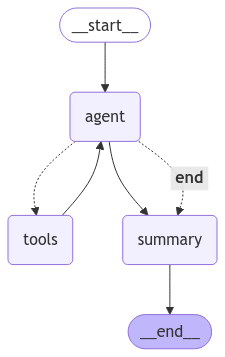

In [7]:
import json
from typing import (
    Annotated,
    Sequence,
    TypedDict,
    List,
)

from pydantic import BaseModel, Field

# LangChain / LangGraph imports
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage,
    BaseMessage,
    ToolMessage,
)
from langchain_core.tools import StructuredTool
from langchain_core.runnables import RunnableConfig

from langgraph.prebuilt import InjectedStore
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from langchain.embeddings import init_embeddings
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

###############################################################################
# 1. Initialize memory + config
###############################################################################
in_memory_store = InMemoryStore(
    index={
        "embed": init_embeddings("huggingface:sentence-transformers/all-MiniLM-L6-v2"),
        "dims": 384,  # Embedding dimensions
    }
)

# A memory saver to checkpoint conversation states
checkpointer = MemorySaver()

# Initialize config with user & thread info
config = {}
config["configurable"] = {
    "user_id": "user_1",
    "thread_id": 0,
}

###############################################################################
# 2. Define MessagesState
###############################################################################
class MessagesState(TypedDict):
    """The state of the agent.

    The key 'messages' uses add_messages as a reducer,
    so each time this state is updated, new messages are appended.
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]


###############################################################################
# 3. Memory Tools
###############################################################################
def save_memory(summary_text: str, *, config: RunnableConfig, store: BaseStore) -> str:
    """Save the given memory for the current user and return the key."""
    user_id = config.get("configurable", {}).get("user_id")
    thread_id = config.get("configurable", {}).get("thread_id")
    namespace = (user_id, "memories")
    memory_id = thread_id
    store.put(namespace, memory_id, {"summary": summary_text})
    return memory_id

def update_memory(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    # Extract the messages list from the event, handling potential missing key
    messages = state["messages"]
    # Convert LangChain messages to dictionaries before storing
    messages_as_dicts = [_convert_message_to_dict(msg) for msg in messages]

    # Get the user id from the config
    user_id = config.get("configurable", {}).get("user_id")
    thread_id = config.get("configurable", {}).get("thread_id")
    # Namespace the memory
    namespace = (user_id, "memories")
    # Create a new memory ID
    memory_id = f"{thread_id}_{str(uuid.uuid4())}"
    store.put(namespace, memory_id, {"memory": messages_as_dicts})
    return memory_id


# Define a Pydantic schema for the save_memory tool (if needed elsewhere)
# https://langchain-ai.github.io/langgraphjs/reference/classes/checkpoint.InMemoryStore.html
class RecallMemory(BaseModel):
    query_text: str = Field(..., title="Search Text", description="The text to search from memories for similar records.")
    k: int = Field(5, title="Number of Results", description="Number of results to retrieve.")

def recall_memory(query_text: str, k: int = 5) -> str:
    """Retrieve user memories from in_memory_store."""
    user_id = config.get("configurable", {}).get("user_id")
    namespace = (user_id, "memories")

    memories = [m.value["data"] for m in in_memory_store.search(namespace=namespace, query=query_text, limit=k)]
    joined = f"User memories: {', '.join(memories)}"
    return joined

# Create a StructuredTool from the function
recall_memory_tool = StructuredTool.from_function(
    func=recall_memory,
    name="Recall Memory Tool",
    description="""
      Retrieve memories relevant to the user's query.
      """,
    args_schema=RecallMemory,
    response_format="content",
    return_direct=False,
    verbose=False
)

###############################################################################
# 4. Summarize Node (using StructuredTool)
###############################################################################
# Define a Pydantic schema for the Summary tool
class SummariseConversation(BaseModel):
    summary_text: str = Field(..., title="text", description="Summary of Conversation")

def summarise_node(summary_text: str):
    """
    Final node that summarizes the entire conversation for the current thread,
    saves it in memory, increments the thread_id, and ends the conversation.
    Returns a confirmation string.
    """
    user_id = config["configurable"]["user_id"]
    current_thread_id = config["configurable"]["thread_id"]
    new_thread_id = str(int(current_thread_id) + 1)

    # Prepare configuration for saving memory with updated thread id
    config_for_saving = {
        "configurable": {
            "user_id": user_id,
            "thread_id": new_thread_id
        }
    }
    key = save_memory(summary_text, config=config_for_saving, store=in_memory_store)
    return f"Summary saved under key: {key}"

# Create a StructuredTool from the function (this wraps summarise_node)
summarise_tool = StructuredTool.from_function(
    func=summarise_node,
    name="Summary Tool",
    description="""
      Summarize the current conversation in no more than
      1000 words. Also retain any unanswered quiz questions along with
      your internal answers so the next conversation thread can continue.
      Do not reveal solutions to the user yet. Use this tool to save
      the current conversation to memory and then end the conversation.
      """,
    args_schema=SummariseConversation,
    response_format="content",
    return_direct=False,
    verbose=True
)

###############################################################################
# 5. Build the Graph
###############################################################################
graph_builder = StateGraph(MessagesState)

# Use the built-in ToolNode from langgraph that calls any declared tools.
tools = [
    mcq_retriever_tool,
    web_extraction_tool,
    ensemble_retriever_tool,
    general_retriever_tool,
    in_memory_retriever_tool,
    recall_memory_tool,
    summarise_tool,  # Use the StructuredTool version, not the raw function
]

tool_node = ToolNode(tools=tools)
end_node = ToolNode(tools=[summarise_tool])  # Use summarise_tool for end node

from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate


# Wrap the Custom ChatvLLM over the base_vllm model
#model = BaseChat_vLLMWrapper(base_vllm)


# Wrap your model with tools
llm_with_tools = model.bind_tools(tools)

###############################################################################
# 6. The agent's main node: call_model
###############################################################################
def call_model(state: MessagesState, config: RunnableConfig):
    """
    The main agent node that calls the LLM with the user + system messages.
    Since our vLLM chat wrapper expects a list of BaseMessage objects,
    we convert any dict messages to HumanMessage objects.
    If the LLM requests a tool call, we'll route to the 'tools' node next
    (depending on the condition).
    """
    # Convert message dicts to HumanMessage instances if needed.
    messages = []
    for m in state["messages"]:
        if isinstance(m, dict):
            # Use role from dict (defaulting to 'user' if missing)
            messages.append(HumanMessage(content=m.get("content", ""), role=m.get("role", "user")))
        else:
            messages.append(m)

    # Invoke the LLM (with tools) using the converted messages.
    response = llm_with_tools.invoke(messages)

    return {"messages": [response]}

###############################################################################
# 7. Add Nodes & Edges, Then Compile
###############################################################################
graph_builder.add_node("agent", call_model)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("summary", end_node)

# Entry point
graph_builder.set_entry_point("agent")

# def custom_tools_condition(llm_output: dict) -> str:
#     """Return which node to go to next based on the LLM output."""

#     # The LLM's JSON might have a field like {"name": "Recall Memory Tool", "arguments": {...}}.
#     tool_name = llm_output.get("name", None)

#     # If the LLM calls "Summary Tool", jump directly to the 'summary' node
#     if tool_name == "Summary Tool":
#         return "summary"

#     # If the LLM calls any other recognized tool, go to 'tools'
#     valid_tool_names = [t.name for t in tools]  # all tools in the main tool_node
#     if tool_name in valid_tool_names:
#         return "tools"

#     # If there's no recognized tool name, assume we're done => go to summary
#     return "__end__"

# graph_builder.add_conditional_edges(
#     "agent",
#     custom_tools_condition,
#     {
#         "tools": "tools",
#         "summary": "summary",
#         "__end__": "summary",
#     }
# )

# If LLM requests a tool, go to "tools", otherwise go to "summary"
graph_builder.add_conditional_edges("agent", tools_condition, {"tools": "tools", "__end__": "summary"})
#graph_builder.add_conditional_edges("agent", lambda llm_output: "tools" if llm_output.get("name", None) in [t.name for t in tools] else "summary", {"tools": "tools", "__end__": "summary"}

# If we used a tool, return to the agent for final answer or more tools
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("agent", "summary")
graph_builder.set_finish_point("summary")

# Compile the graph with checkpointing and persistent store
graph = graph_builder.compile(checkpointer=checkpointer, store=in_memory_store)

#from langgraph.prebuilt import create_react_agent
#graph = create_react_agent(llm_with_tools, tools=tool_node, checkpointer=checkpointer, store=in_memory_store)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


### Test Questions

In [9]:
# Train of Thought Prompt Template
system_message = """
[SYSTEM PROMPT]

You are an AI Tutor whose purpose is to assist and educate the Human.

[END SYSTEM PROMPT]
"""


In [10]:
# URL
url1 = "https://www.ibm.com/think/topics/artificial-intelligence"
url2 = "https://www.ibm.com/think/topics/machine-learning"

question_1 = (f"Find out about Deep Learning from databases. Then search from website: {url1} and {url2} with web extraction tool")
question_2 = "Provide 5 MCQ questions on Artificial Intelligence to help me with practice."
question_3 = "Here are my answers: 1. A, 2. B, 3. C, 4. D, 5. E. Please check mu answer, provide reasons for my wrong answers and provide the correct answers with explanations."
question_4 = "Provide another 5 MCQ questions on Artificial Intelligence to help me with practice."
question_5 = "Here are my answers: 1. A, 2. B, 3. C, 4. D, 5. E. Please check mu answer, provide reasons for my wrong answers and provide the correct answers with explanations."
question_6 = "Provide a study quide to help me learn for my wrong answers for the MCQ questions."
question_7 = "Based on your reference databases only, provide a study quide on Deep Learning."
question_8 = "Based on your memory, provide a summary of our conversation."
question_9 = "Summarise the conversation so far."

# Grab the current user_id and thread_id from config
user_id = "user_1"

# Get last thread_id
last_thread_id = config["configurable"]["thread_id"]
thread_id = str(int(last_thread_id) + 1)

# Print Config
print(f"Conversation Thread ID: {last_thread_id} -> {thread_id}")

# Update the config with the new thread_id
config = {"configurable": {"thread_id": thread_id, "user_id": user_id}}


# Create a system prompt (your overall instructions to the AI)
system_msg = SystemMessage(content="""
You are a helpful AI Tutor assistant.
After response to Human, call for Summary Tool to END.
""")


#The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [
        {"role": "system", "content": system_message},
        {"role": "user", "content": question_1}]},
    config, # Pass the thread-level persistence to the graph
    stream_mode="values",
)
for event in events:
    response = event["messages"][-1]
    response.pretty_print()


update_memory(event, config, store=in_memory_store) # Update Memory


Conversation Thread ID: 0 -> 1
================================ Human Message =================================

Find out about Deep Learning from databases. Then search from website: https://www.ibm.com/think/topics/artificial-intelligence and https://www.ibm.com/think/topics/machine-learning with web extraction tool
================================== Ai Message ==================================
Tool Calls:
  Assistant References Retrieval Tool (call_5sz3)
 Call ID: call_5sz3
  Args:
    input: Deep Learning
    k: 5
================================= Tool Message =================================
Name: Assistant References Retrieval Tool

["Deep Learning\na machine learning technique in which layers of neural networks are used to process data and make decisions", "Fundamentals of Deep Learning\nPart 5: Pre-trained Models\n•, 1 = Part 1:  An Introduction to Deep Learning. •, 1 = Part 2: How a Neural Network Trains. •, 1 = Part 3: Convolutional Neural Networks. •, 1 = Part 4: Data Augm

'1_71a76744-192f-4906-a6a6-7fe8892e625c'

In [11]:
response.pretty_print()

================================== Ai Message ==================================

It seems there was an issue with the tools available for web extraction. Let me summarize the situation and proceed accordingly.

**Summary of the Situation:**
- You requested information on Deep Learning, both from databases and specific websites.
- The Assistant References Retrieval Tool provided initial information on Deep Learning.
- The Web Extraction Tool was attempted but was invalid, preventing the retrieval of specific website content.
- A summary of the conversation was saved for future reference.

**Next Steps:**
1. **Acknowledge the Limitation:** Unfortunately, the Web Extraction Tool isn't available, so I couldn't gather the specific web content you requested.
2. **Offer Alternatives:** I can provide more detailed information from the database or suggest other topics related to Deep Learning.
3. **Continue Conversation:** We can proceed with the information we have or explore other areas you'

In [12]:
print(response.content)

It seems there was an issue with the tools available for web extraction. Let me summarize the situation and proceed accordingly.

**Summary of the Situation:**
- You requested information on Deep Learning, both from databases and specific websites.
- The Assistant References Retrieval Tool provided initial information on Deep Learning.
- The Web Extraction Tool was attempted but was invalid, preventing the retrieval of specific website content.
- A summary of the conversation was saved for future reference.

**Next Steps:**
1. **Acknowledge the Limitation:** Unfortunately, the Web Extraction Tool isn't available, so I couldn't gather the specific web content you requested.
2. **Offer Alternatives:** I can provide more detailed information from the database or suggest other topics related to Deep Learning.
3. **Continue Conversation:** We can proceed with the information we have or explore other areas you're interested in.

Let me know how you'd like to proceed, and I'll do my best to a

In [ ]:
# Assessing ChatBot Memory
user_id = "user_1"
namespace_for_memory = (user_id, "memories")
memories = in_memory_store.search(namespace_for_memory)

memories[-1].dict()

{'namespace': ['user_1', 'memories'],
 'key': '3_cf5fd8ed-229c-48f7-82b4-92fb472ffe71',
 'value': {'memory': [{'content': 'Provide 5 MCQ questions on Artificial Intelligence to help me with practice.',
    'role': 'user'},
   {'content': None,
    'role': 'assistant',
    'tool_calls': [{'id': 'call_n6we',
      'function': {'arguments': '{"input": "Artificial Intelligence", "k": 5}',
       'name': 'MCQ Retrieval Tool'},
      'type': 'function'}]},
   {'content': 'Error: MCQ Retrieval Tool is not a valid tool, try one of [Summary Tool].',
    'name': 'MCQ Retrieval Tool',
    'role': 'tool',
    'tool_call_id': 'call_n6we'},
   {'content': '{"./Documents/mcq/mcq.csv_Qn2 mcq_question": "Your organization is developing a decision support solution to monitor data for anomalies and deliver real-time insights to stakeholders. The solution requires continuous monitoring and automated alerts for deviations from expected patterns. Which Azure AI service should you select to implement the dat